# Covid-19: From model prediction to model predictive control

## JPGMs tryout of the QALY calculation

*Original code by Juan Pablo Gallo. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by BIOMATH, Ghent University. All Rights Reserved.

This notebook contains a demo calculation of the number of *Quality adjusted life years* lost due to COVID-19. The calculation is performed ex-post simulation. The calculation is a simple manipulation of the number of predicted deaths. 

For this demo, the deterministic national-level model was used. All details with regard to the model can be found in our preprint *A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*, which can be found here: https://www.medrxiv.org/content/10.1101/2020.07.17.20156034v2

In [1]:
import gc
import sys, getopt
import ujson as json
import random
import datetime
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Load the covid 19 custom development code

In [2]:
from covid19model.models import models
from covid19model.data import mobility, sciensano, model_parameters, VOC
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator 

In [3]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [4]:
# --------------------------
# Define simulation settings
# --------------------------

N=30
k=1
# Start and end of simulation
start_sim = '2020-09-01'
end_sim = '2021-09-01'
# Confidence level used to visualise model fit
conf_int = 0.05
# Path where figures and results should be stored
fig_path = '../../results/calibrations/COVID19_SEIRD/national/others/WAVE2/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'

## Model initialization

In [5]:
# -----------------------
# Load samples dictionary
# -----------------------

from covid19model.models.utils import load_samples_dict
samples_dict = load_samples_dict(samples_path+'BE_WAVE2_R0_COMP_EFF_'+'2021-05-28'+'.json', wave=2)
warmup = int(samples_dict['warmup'])

# ---------
# Load data
# ---------

# Time-integrated contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices()
levels = initN.size
# Sciensano public data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
# Sciensano mortality data
df_sciensano_mortality =sciensano.get_mortality_data()
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)
# Serological data
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()
# VOC data
df_VOC_501Y = VOC.get_501Y_data()
# Start of data collection
start_data = df_sciensano.idxmin()
# Start of calibration warmup and beta
start_calibration = samples_dict['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict['end_calibration']

# ---------------------------
# Time-dependant VOC function
# ---------------------------

from covid19model.models.time_dependant_parameter_fncs import make_VOC_function
VOC_function = make_VOC_function(df_VOC_501Y)

# -----------------------------------
# Time-dependant vaccination function
# -----------------------------------

from covid19model.models.time_dependant_parameter_fncs import  make_vaccination_function
vacc_strategy = make_vaccination_function(df_sciensano)

# --------------------------------------
# Time-dependant social contact function
# --------------------------------------

# Extract build contact matrix function
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function, delayed_ramp_fun, ramp_fun
contact_matrix_4prev = make_contact_matrix_function(df_google, Nc_all)
policies_WAVE2_full_relaxation = make_contact_matrix_function(df_google, Nc_all).policies_WAVE2_full_relaxation
    
# ---------------------------------------------------
# Function to add poisson draws and sampling function
# ---------------------------------------------------

from covid19model.models.utils import output_to_visuals,draw_fcn_WAVE2

# --------------------
# Initialize the model
# --------------------

# Model initial condition on September 1st
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/initial_states_2020-09-01.json', 'r') as fp:
    initial_states = json.load(fp)    
# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters(vaccination=True)
# Add the time-dependant parameter function arguments
# Social policies
params.update({'l': 21, 'prev_schools': 0, 'prev_work': 0.5, 'prev_rest': 0.5, 'prev_home': 0.5, 'relaxdate': '2021-06-01', 'l_relax': 31})
# VOC
params.update({'t_sig': '2021-07-01'})
# Vaccination
params.update(
    {'vacc_order': np.array(range(9))[::-1], 'daily_dose': 55000,
     'refusal': 0.2*np.ones(9), 'delay': 20}
)
# Initialize model
model = models.COVID19_SEIRD_vacc(initial_states, params,
                        time_dependent_parameters={'Nc': policies_WAVE2_full_relaxation, 'N_vacc': vacc_strategy, 'alpha':VOC_function})


## Perform simulation

In [6]:
# -------------------
# Perform simulations
# -------------------

print('\n1) Simulating COVID-19 SEIRD '+str(N)+' times')
start_sim = start_calibration
out = model.sim(end_sim,start_date=start_sim,warmup=warmup,N=N,draw_fcn=draw_fcn_WAVE2,samples=samples_dict)
simtime, df_2plot = output_to_visuals(out, ['H_in', 'H_tot', 'ICU', 'D', 'R'], N, k, LL = conf_int/2, UL = 1 - conf_int/2)


1) Simulating COVID-19 SEIRD 10 times


## Visualize the total number of patients in the hospital and the predicted number of deaths in the hospital

2) Visualizing fit on deaths


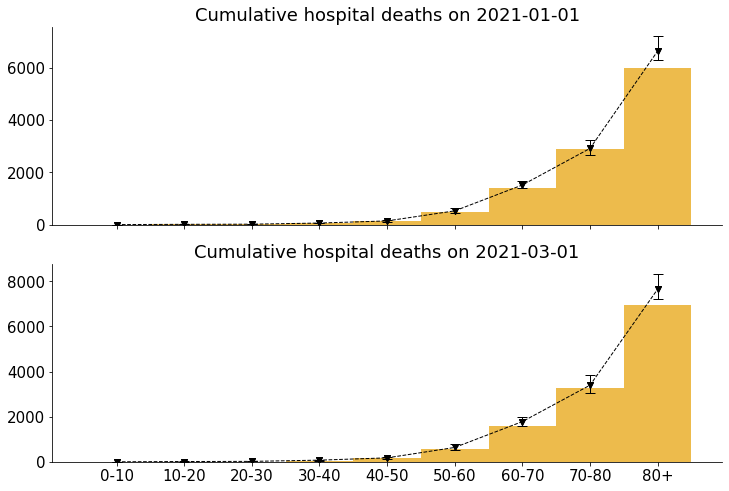

In [7]:
print('2) Visualizing fit on deaths')

dates = ['2021-01-01','2021-03-01']

fig,axes = plt.subplots(nrows=len(dates),ncols=1,figsize=(12,4*len(dates)),sharex=True)
for idx,date in enumerate(dates):
    data_sciensano = []
    for jdx,age_group in enumerate(df_sciensano_mortality.index.get_level_values(0).unique().values[1:]):
        data_sciensano.append(df_sciensano_mortality.xs(key=age_group, level="age_class", drop_level=True).loc[dates[idx]]['hospital','cumsum'])
    
    axes[idx].scatter(df_sciensano_mortality.index.get_level_values(0).unique().values[1:],out['D'].mean(dim='draws').loc[dict(time=date)],color='black',marker='v',zorder=1)
    yerr = np.zeros([2,len(out['D'].quantile(dim='draws',q=0.975).loc[dict(time=date)].values)])
    yerr[0,:] = out['D'].mean(dim='draws').loc[dict(time=date)] - out['D'].quantile(dim='draws',q=0.025).loc[dict(time=date)].values
    yerr[1,:] = out['D'].quantile(dim='draws',q=0.975).loc[dict(time=date)].values - out['D'].mean(dim='draws').loc[dict(time=date)]
    axes[idx].errorbar(x=df_sciensano_mortality.index.get_level_values(0).unique().values[1:],
                       y=out['D'].mean(dim='draws').loc[dict(time=date)],
                       yerr=yerr,
                       color = 'black', fmt = '--v', zorder=1, linewidth=1, ecolor='black', elinewidth=1, capsize=5)
    axes[idx].bar(df_sciensano_mortality.index.get_level_values(0).unique().values[1:],data_sciensano,width=1,alpha=0.7,zorder=0)
    axes[idx].set_title('Cumulative hospital deaths on '+date)
    axes[idx].grid(False)
plt.show()

## QALY calculations

In [8]:
# Obtain the number of QALYs that would be lost if a person of a given age dies
from covid19model.models.QALY import *

### Quality of life parameters

In [9]:
#Standarized Mortality ratio. It is used to adjust for increased mortality
#due to comorbidities. It modifies l(x), the term in life tables that
#corresponds to the number of people per 100000 hab that survives to age x
SMR=1

#Adjustment paramter to account for additional impact on quality of life 
#due to comorbidity
qCM=1

#Disccount rate. It is included due to the time preference. Things in the present
#are valued more than in the future. 5% is standard practice
r=0.03

##Import input data##
#Belgian life table information
#x: Age
#q_x: Probability that someone aged exactly x will die before reaching age x+1
input_life_table=pd.read_csv('../../data/interim/QALYs/Life_table_Belgium_2019.csv',sep=';')

#Belgian EQ-5D QoL Survey data
input_QoL=pd.read_csv('../../data/interim/QALYs/QoL_scores_Belgium_2018_v3.csv',sep=';')

#Calculate and output age-stratified parameters
lost_QALY_pp=get_QALY_parameters(input_life_table,input_QoL,SMR,qCM,r)

### Perform the QALY calculation and add to the xarray output of the model

In [31]:
out = QALY2xarray(out,lost_QALY_pp)

### Visualize number of QALYs lost

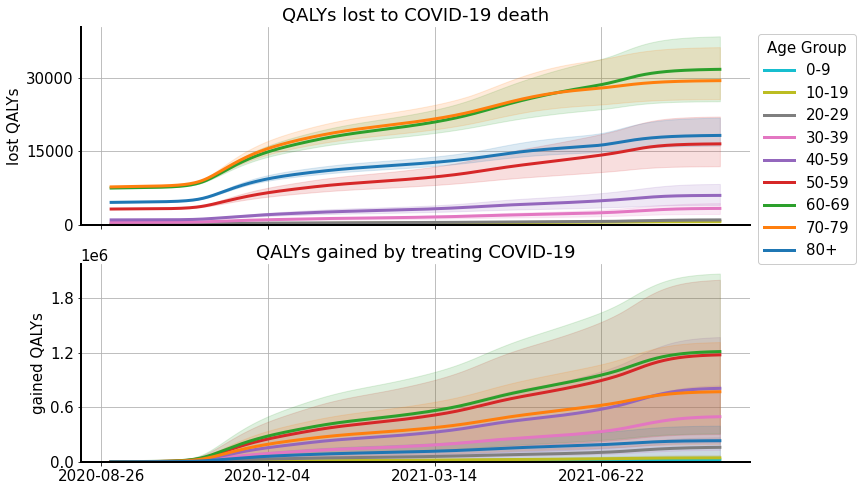

In [32]:
#Plot

Palette=cm.get_cmap('tab10_r', levels).colors
age_group=['0-9','10-19','20-29','30-39','40-59','50-59','60-69','70-79','80+']

fig, axs = plt.subplots(2,figsize=(12,8),sharex=True)

states = ['QALY_death','QALY_treatment_cumsum']
title = ['QALYs lost to COVID-19 death', 'QALYs gained by treating COVID-19']
ylabel = ['lost QALYs','gained QALYs']

for j in range(len(states)):
    ax = axs[j]
    for i in range(levels):        
        ax.plot(simtime,out[states[j]].mean(dim="draws")[i],linewidth=3, label=age_group[i],color=Palette[i])
        ax.fill_between(simtime,out[states[j]].quantile(1-conf_int/2,dim="draws")[i],out[states[j]].quantile(conf_int/2,dim="draws")[i], alpha = 0.15, color=Palette[i])

    ax.set_title(title[j])
    ax.set_ylim(bottom=0)
    ax.set_ylabel(ylabel[j])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.set_axisbelow(True)
    if j == 0:
        ax.legend(fancybox=True, frameon=True, framealpha=1, fontsize=15,title='Age Group', loc="upper left", bbox_to_anchor=(1,1))  
    # limit the number of ticks on the axis
    ax = _apply_tick_locator(ax)
   
# save figure
plt.savefig('../../results/QALYs/QALYs_gained_lost.jpg',bbox_inches='tight',dpi=300)

###  The effect of hospital care reduction vs. COVID-19
+ In the folowing example, the loss of life due to a constant average percentual reduction in regular hospital is calculated and compared with the overall loss of life to Covid-19.
+ The provided function can be used to investigate the effect of time-dependent changes in hospital care as well as reductions in the treatment of different disease categories.

In [33]:
from covid19model.models.QALY import lost_QALY_hospital_care

# Define percentual reduction range
reduction_range=np.linspace(0.10,0.99,100)
# Calculate QALYs lost due to hospital care reduction
lost_hospital=lost_QALY_hospital_care(reduction_range)/365
# Calculate how much QALYs are lost over a time period delta_T
delta_T = (simtime[-1]-simtime[0])/pd.Timedelta(days=1)
QALY_indirect = lost_hospital*delta_T
# Extract direct QALY loss from model
QALY_direct_mean = np.cumsum(out['QALY_treatment'].mean(dim="draws").sum(dim="Nc").values)[-1]
QALY_direct_lower = np.cumsum(out['QALY_treatment'].quantile(conf_int/2,dim="draws").sum(dim="Nc").values)[-1]
QALY_direct_upper = np.cumsum(out['QALY_treatment'].quantile(1-conf_int/2,dim="draws").sum(dim="Nc").values)[-1]
# Calculate ratio
ratio_mean = QALY_direct_mean/QALY_indirect
ratio_upper = QALY_direct_lower/QALY_indirect
ratio_lower = QALY_direct_upper/QALY_indirect
#ratio_data = sum(deaths*lost_QALY_pp)/QALY_indirect

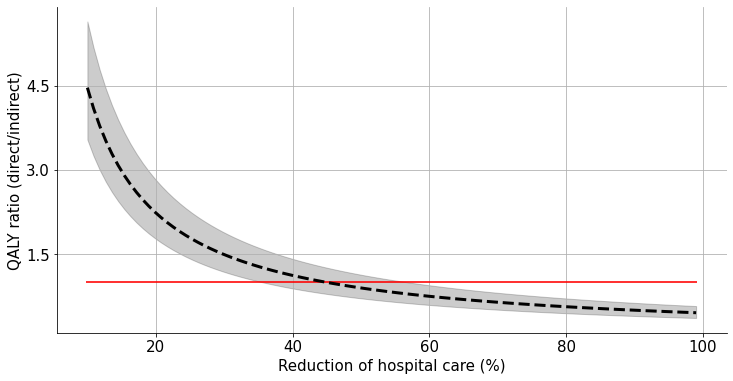

In [34]:
from covid19model.visualization.output import _apply_tick_locator

# Initialize plot
fig,ax = plt.subplots(figsize=(12,6))

# Add lines
ax.plot(reduction_range*100,np.ones(100),color='red',alpha=0.8,linewidth=2)
ax.plot(reduction_range*100,ratio_mean,'--',color='black')
ax.fill_between(reduction_range*100,ratio_lower,ratio_upper,alpha=0.2,color='black')

# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)

# labels and title
ax.set_xlabel('Reduction of hospital care (%)')
ax.set_ylabel('QALY ratio (direct/indirect)')
#plt.title('Comparison of qualitative life years lost\n directly vs. indirectly to SARS-CoV-2')

# save figure
plt.savefig('../../results/QALYs/QALY_ratio.pdf',dpi=300)